In [1]:
%load_ext autoreload
%autoreload 2
p = print

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from crypr.zoo import LSTM_triggerNG, LSTM_WSAEs, build_ae_lstm
from crypr.util import get_project_path

Using TensorFlow backend.


In [2]:
"""
Import Data.
"""
SYM = 'BTC'
Ty = 1
Tx = 72
num_channels = 1
wt_type = 'haar'
data_dir = os.path.join(get_project_path(), 'data', 'processed')

X_train = np.load(os.path.join(data_dir, 'X_train_{}_{}_smooth_{}.npy'.format(SYM, wt_type, Tx)))
X_test = np.load(os.path.join(data_dir, 'X_test_{}_{}_smooth_{}.npy'.format(SYM, wt_type, Tx)))
y_train = np.load(os.path.join(data_dir, 'y_train_{}_{}_smooth_{}.npy'.format(SYM, wt_type, Tx)))
y_test = np.load(os.path.join(data_dir, 'y_test_{}_{}_smooth_{}.npy'.format(SYM, wt_type, Tx)))

In [3]:
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((5629, 1, 72), (297, 1, 72), (297, 1), (5629, 1))

In [4]:
if len(X_train.shape) < 3:
    model_X_train = np.swapaxes(np.expand_dims(X_train, axis=-1), axis1=-2, axis2=-1)
    model_X_test = np.swapaxes(np.expand_dims(X_test, axis=-1), axis1=-2, axis2=-1)
else:
    model_X_train = X_train
    model_X_test = X_test
model_X_train.shape

(5629, 1, 72)

In [5]:
"""
Evaluate Dummy Models.
"""
for strategy in ['mean', 'median', 'constant']:
    
    if strategy=='constant':
        dummy=DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy=DummyRegressor(strategy=strategy)
        
    p('\nTraining dummy model on training data with strategy {} ...'.format(strategy))
    dummy.fit(X_train, y_train)
    
    p('\nPerformance on train data:')
    dummy_predict_train = dummy.predict(X_train)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_train, y_pred=dummy_predict_train)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_train, y_pred=dummy_predict_train)))
    
    p('\nPerformance on test data:')
    dummy_predict_test = dummy.predict(X_test)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_test, y_pred=dummy_predict_test)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_test, y_pred=dummy_predict_test)))


Training dummy model on training data with strategy mean ...

Performance on train data:
mean MAE: 0.3685907822780149
mean MSE: 0.48241478792244674

Performance on test data:
mean MAE: 0.22173177276079079
mean MSE: 0.21816986175239914

Training dummy model on training data with strategy median ...

Performance on train data:
median MAE: 0.3684412225573951
median MSE: 0.48250360760060407

Performance on test data:
median MAE: 0.22109031078430322
median MSE: 0.2185175953046493

Training dummy model on training data with strategy constant ...

Performance on train data:
constant MAE: 0.3684570118593815
constant MSE: 0.48245071329994665

Performance on test data:
constant MAE: 0.22124047352234621
constant MSE: 0.21837045216673828


In [6]:
"""
Define model.
"""
model_type = 'ae_lstm'

if model_type == 'ae_lstm':
    model = build_ae_lstm(num_inputs=model_X_train.shape[-1], num_channels=1, num_outputs=Ty)
else:
    model = None
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 1, 72)        0                                            
__________________________________________________________________________________________________
encoder (Dense)                 (None, 1, 36)        2628        input_0[0][0]                    
__________________________________________________________________________________________________
encoded (Dense)                 (None, 1, 18)        666         encoder[0][0]                    
__________________________________________________________________________________________________
rs_0 (Reshape)       

In [7]:
"""
Set model training parameters.
"""
epochs = 10
batch_size = 32
learning_rate = .001
beta_1 = 0.9
beta_2 = 0.999
decay = 0.01  # TODO: Calculate decay rate? -- decay = learning_rate / epochs

"""
Compile and fit model.
"""
# Callback definition
tensorboard = TensorBoard(log_dir='logs/{}'.format('ae_lstm_l1_10e-6'), histogram_freq=0, batch_size=batch_size, 
                          write_graph=True, write_grads=False, write_images=False)

opt = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, decay=decay)

model.compile(loss='mae', optimizer=opt)

fit = model.fit(model_X_train, [model_X_train, y_train],
                shuffle=False,
                epochs=epochs, 
                batch_size=batch_size, 
                validation_data=(model_X_test, [model_X_test, y_test]),
                callbacks=[tensorboard]
               )

Instructions for updating:
Use tf.cast instead.
Train on 5629 samples, validate on 297 samples
Epoch 1/10
5629/5629 [==============================] - 14s 2ms/step - loss: 0.4331 - decoded_loss: 0.0528 - dense_0_loss: 0.3802 - val_loss: 0.2768 - val_decoded_loss: 0.0387 - val_dense_0_loss: 0.2381
Epoch 2/10
5629/5629 [==============================] - 11s 2ms/step - loss: 0.4143 - decoded_loss: 0.0434 - dense_0_loss: 0.3709 - val_loss: 0.2633 - val_decoded_loss: 0.0362 - val_dense_0_loss: 0.2271
Epoch 3/10
5629/5629 [==============================] - 11s 2ms/step - loss: 0.4125 - decoded_loss: 0.0420 - dense_0_loss: 0.3705 - val_loss: 0.2585 - val_decoded_loss: 0.0355 - val_dense_0_loss: 0.2230
Epoch 4/10
5629/5629 [==============================] - 12s 2ms/step - loss: 0.4116 - decoded_loss: 0.0415 - dense_0_loss: 0.3701 - val_loss: 0.2583 - val_decoded_loss: 0.0352 - val_dense_0_loss: 0.2231
Epoch 5/10
5629/5629 [==============================] - 11s 2ms/step - loss: 0.4099 - decoded

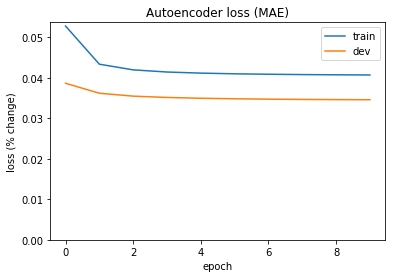

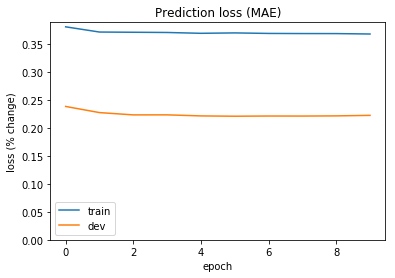

In [8]:
"""
Check out autoencoder loss from train and dev sets
"""
plt.plot(fit.history['decoded_loss'], label='train')
plt.plot(fit.history['val_decoded_loss'], label='dev')
plt.title('Autoencoder loss (MAE)')
plt.ylabel('loss (% change)')
plt.xlabel('epoch')
plt.ylim([0, None])
plt.legend()
plt.show()

"""
Check out prediction loss from train and dev sets
"""
plt.plot(fit.history['dense_0_loss'], label='train')
plt.plot(fit.history['val_dense_0_loss'], label='dev')
plt.title('Prediction loss (MAE)')
plt.ylabel('loss (% change)')
plt.xlabel('epoch')
plt.ylim([0, None])
plt.legend()
plt.show()

In [9]:
backtest = model.predict(model_X_train)[1]
prediction = model.predict(model_X_test)[1]

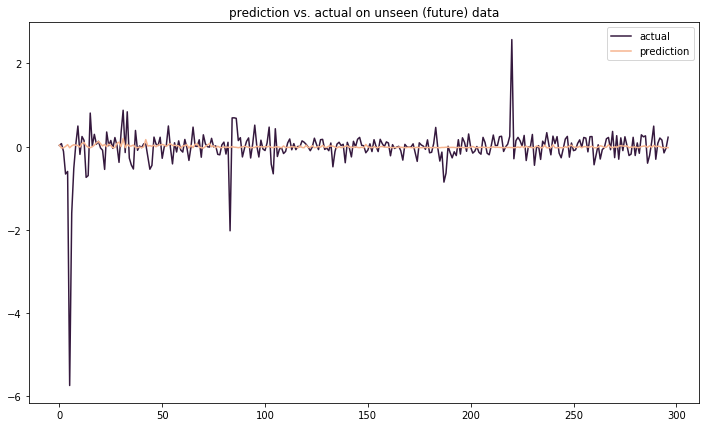

In [10]:
fig,ax = plt.subplots(figsize=(12,7))
plt.plot(y_test, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(prediction, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on unseen (future) data')
plt.legend()
plt.show()

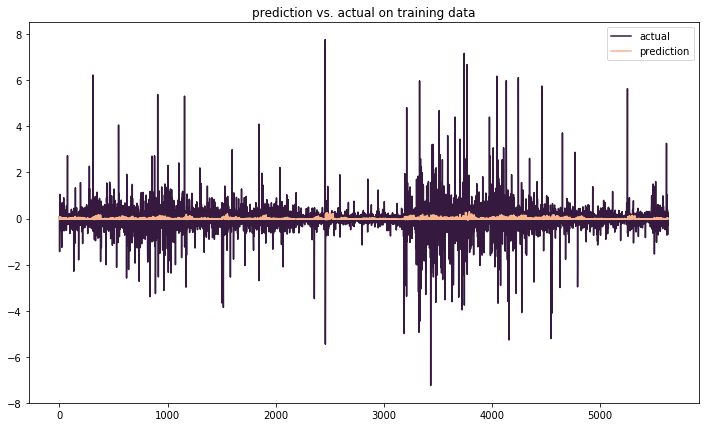

In [11]:
fig,ax = plt.subplots(figsize=(12,7))
plt.plot(y_train, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(backtest, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on training data')
plt.legend()
plt.show()

In [12]:
# """
# Save the model.
# """
# model.save(filepath='../models/{}_smooth_{}x{}_{}_{}.h5'.format(model_type, num_channels, Tx, wavelet, SYM))